In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import matplotlib.colors as mcolors
import anndata as ad
import seaborn as sns
import anndata2ri as an

In [5]:
input_file = "raw_data/sc_cll_3ca.h5ad"

# Load the .h5ad file
sc_adata = sc.read_h5ad(input_file)

In [6]:
sc_adata

AnnData object with n_obs × n_vars = 720 × 55764
    obs: 'sample', 'patient', 'sample_status', 'complexity'

In [7]:
sc_adata

AnnData object with n_obs × n_vars = 720 × 55764
    obs: 'sample', 'patient', 'sample_status', 'complexity'

In [8]:
# CLL-map tables - 
# import into your code as module with "import config_cllmap_tables"
# import config_cllmap_tables
# and then save the tables as variables, for example
# master_table = config_cllmap_tables.master_table

path = "/private/resources/"

# expression data
tpms_603samps_deseqLog10_batchcorr = pd.read_csv(path + "cll_tables/cllmap_rnaseq_tpms_603samps_deseqLog10_batchcorr.tsv", sep="\t")
cllmap_rnaseq_tpms_full = pd.read_csv(path + "cll_tables/cllmap_rnaseq_tpms_full.tsv", sep="\t")


In [9]:
df = cllmap_rnaseq_tpms_full


# The first two columns are used for `var`
var = df.iloc[:, :2].set_index('Description')

# The remaining columns are used for `obs`
obs = pd.DataFrame(index=df.columns[2:])

# The data matrix is the remaining part of the DataFrame, transposed
X = df.iloc[:, 2:].values.T

# Create the AnnData object with the data matrix, `obs`, and `var`
adata = sc.AnnData(X=X, obs=obs, var=var)


/data01/home/ls/razlans/miniforge3/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [10]:
master_table = pd.read_csv(path + "cll_tables/cllmap_master_table.20220622.tsv", sep="\t")
ec_table = master_table[["participant_id", "ec_name"]]

In [11]:
filtered_ec_table = ec_table[ec_table['participant_id'].isin(adata.obs.index)]
filtered_ec_table = filtered_ec_table.dropna(subset=['ec_name'])
# Reset the indices of the filtered_ec_table
filtered_ec_table.reset_index(drop=True, inplace=True)

adata_filtered = adata[filtered_ec_table['participant_id'].values].copy()

# # Saving the filtered_ec_table as CSV
# filtered_ec_table.to_csv('filtered_ec_table.csv', index=False)

# df_X = pd.DataFrame(data=adata_filtered.X, index=adata_filtered.obs_names, columns=adata_filtered.var_names)
# df_X.to_csv('adata_X.csv')



/data01/home/ls/razlans/miniforge3/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [12]:
filtered_ec_table.set_index("participant_id", inplace=True)
# Initialize a new column for ec_name in adata.obs with default values
adata_filtered.obs['ec_name'] = None  # Or pd.NA for pandas' NA values

# Loop through each observation
for idx in adata_filtered.obs.index:
    if idx in filtered_ec_table.index:
        adata_filtered.obs.at[idx, 'ec_name'] = filtered_ec_table.at[idx, 'ec_name']
    else:
        print(f"No matching participant_id found for {idx}")  # Optional: for debugging


In [13]:
filtered_ec_table

,ec_name
participant_id,
CRC-0001,EC-u1
CRC-0002,EC-u1
CRC-0003,EC-u2
CRC-0004,EC-m4
CRC-0005,EC-u2
...,...
SCLL-0499,EC-m1
SCLL-0502,EC-m4
SCLL-0503,EC-m1


In [14]:
adata_filtered

AnnData object with n_obs × n_vars = 603 × 57242
    obs: 'ec_name'
    var: 'Name'

In [15]:
from rpy2.robjects import r
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from scipy.sparse import coo_matrix

adata_filtered.X = coo_matrix(adata_filtered.X)
sc_adata.X = coo_matrix(sc_adata.X)
adata_filtered.layers["logcounts"] = adata_filtered.X.copy()

ref_data = an.py2rpy(adata_filtered)
test_data = an.py2rpy(sc_adata)

ec_name_series = adata_filtered.obs["ec_name"].to_list()
r_labels = robjects.StrVector(ec_name_series)


/data01/home/ls/razlans/miniforge3/envs/sc/lib/python3.12/functools.py:909: UserWarning: Duplicated var_names: Index(['5S_rRNA', '5S_rRNA', '5S_rRNA', '5S_rRNA', '5S_rRNA', '5S_rRNA',
       '5S_rRNA', '7SK', '7SK', '7SK',
       ...
       'snoU13', 'snoU2_19', 'snoU2_19', 'snoU2_19', 'snoZ6', 'snoZ6', 'snoZ6',
       'snoZ6', 'snosnR60_Z15', 'snosnR60_Z15'],
      dtype='object', name='Description', length=2216)
  return dispatch(args[0].__class__)(*args, **kw)


In [16]:
print(r_labels.r_repr())

c("EC-u1", "EC-u1", "EC-u2", "EC-m4", "EC-u2", "EC-u1", "EC-m3", 
"EC-m4", "EC-u1", "EC-i", "EC-o", "EC-m1", "EC-m4", "EC-o", "EC-m1", 
"EC-u1", "EC-u1", "EC-u1", "EC-m4", "EC-u1", "EC-u1", "EC-u2", 
"EC-u1", "EC-u1", "EC-m3", "EC-m4", "EC-i", "EC-i", "EC-m2", 
"EC-m4", "EC-m3", "EC-u1", "EC-m2", "EC-m2", "EC-m4", "EC-m4", 
"EC-o", "EC-m4", "EC-m3", "EC-u1", "EC-m1", "EC-m2", "EC-m3", 
"EC-m2", "EC-m1", "EC-m2", "EC-m4", "EC-u1", "EC-o", "EC-u1", 
"EC-u1", "EC-u2", "EC-m1", "EC-u2", "EC-m4", "EC-o", "EC-u2", 
"EC-m3", "EC-u1", "EC-i", "EC-u1", "EC-m4", "EC-u1", "EC-m3", 
"EC-m3", "EC-m2", "EC-m3", "EC-u1", "EC-m4", "EC-m4", "EC-u2", 
"EC-m3", "EC-m3", "EC-o", "EC-m4", "EC-m2", "EC-u1", "EC-m4", 
"EC-m2", "EC-o", "EC-o", "EC-u1", "EC-u1", "EC-m1", "EC-m4", 
"EC-i", "EC-m2", "EC-m4", "EC-u2", "EC-i", "EC-m4", "EC-m4", 
"EC-i", "EC-m2", "EC-u2", "EC-m1", "EC-m2", "EC-m4", "EC-u2", 
"EC-u1", "EC-u1", "EC-m2", "EC-m4", "EC-m4", "EC-u1", "EC-u1", 
"EC-u1", "EC-m4", "EC-u1", "EC-u2", "EC-i", 

In [17]:
SingleR = importr('SingleR')

result = SingleR.SingleR(
    test=test_data,
    assay_type_test=1,
    ref=ref_data,
    labels=r_labels
)

In [18]:
result_names = [name for name in result.names]
print(result_names)



['scores', 'labels', 'delta.next', 'pruned.labels']


In [19]:
slot_names = r['slotNames'](result)
print(slot_names)

[1] "rownames"        "nrows"           "elementType"     "elementMetadata"
[5] "metadata"        "listData"       



In [20]:
# Access the 'listData' slot of the S4 object
list_data = r['slot'](result, 'listData')

# Print available names in 'listData' to identify components
list_data_names = r['names'](list_data)
print(list_data_names)

[1] "scores"        "labels"        "delta.next"    "pruned.labels"



In [21]:

print(list_data.rx2('pruned.labels'))

  [1] "EC-m3" "EC-m3" "EC-m3" "EC-m3" "EC-m4" "EC-m1" "EC-m3" "EC-m3" "EC-m3"
 [10] "EC-m4" "EC-m4" "EC-m3" "EC-m3" "EC-m4" "EC-m1" "EC-m3" "EC-m4" "EC-m4"
 [19] "EC-m4" "EC-m3" "EC-m3" "EC-m4" "EC-m3" "EC-m1" "EC-m3" "EC-m4" "EC-m4"
 [28] "EC-m3" "EC-m4" "EC-m3" "EC-m3" "EC-m3" "EC-m3" "EC-m4" "EC-m4" "EC-m3"
 [37] "EC-m3" "EC-m3" "EC-m4" "EC-m4" "EC-m4" "EC-m3" "EC-m1" "EC-m3" "EC-m3"
 [46] "EC-m3" "EC-m4" "EC-m4" "EC-m4" "EC-m4" "EC-m3" "EC-m3" "EC-m1" "EC-m3"
 [55] "EC-m3" "EC-m1" "EC-m4" "EC-m3" "EC-m3" "EC-m3" "EC-m1" "EC-m3" "EC-m3"
 [64] "EC-m4" "EC-m3" "EC-m4" "EC-m3" "EC-m4" "EC-m1" "EC-m4" "EC-m4" "EC-m4"
 [73] "EC-m3" "EC-m1" "EC-m1" "EC-m3" "EC-m4" "EC-m1" "EC-m3" "EC-m3" "EC-m3"
 [82] "EC-m1" "EC-m4" "EC-m4" "EC-m3" "EC-m3" "EC-m3" "EC-m3" "EC-m3" "EC-m4"
 [91] "EC-m3" "EC-m3" "EC-m3" "EC-m3" "EC-m3" "EC-m3" "EC-m3" "EC-m1" "EC-m1"
[100] "EC-m1" "EC-m3" "EC-m3" "EC-m3" "EC-m1" "EC-m1" "EC-m1" "EC-m3" "EC-m1"
[109] "EC-m1" "EC-m1" "EC-m3" "EC-m1" "EC-m4" "EC-m1" "EC-m3" "E

In [22]:
list_rows = r['slot'](result, 'rownames')
# Print available names in 'listData' to identify components
list_rows_names = r['names'](list_rows)
print(list_rows)

  [1] "CLL03_T0_cDNA_A10_S202" "CLL03_T0_cDNA_A11_S203" "CLL03_T0_cDNA_A12_S204"
  [4] "CLL03_T0_cDNA_A1_S193"  "CLL03_T0_cDNA_A2_S194"  "CLL03_T0_cDNA_A3_S195" 
  [7] "CLL03_T0_cDNA_A4_S196"  "CLL03_T0_cDNA_A5_S197"  "CLL03_T0_cDNA_A6_S198" 
 [10] "CLL03_T0_cDNA_A7_S199"  "CLL03_T0_cDNA_A8_S200"  "CLL03_T0_cDNA_A9_S201" 
 [13] "CLL03_T0_cDNA_B10_S214" "CLL03_T0_cDNA_B11_S215" "CLL03_T0_cDNA_B12_S216"
 [16] "CLL03_T0_cDNA_B1_S205"  "CLL03_T0_cDNA_B2_S206"  "CLL03_T0_cDNA_B3_S207" 
 [19] "CLL03_T0_cDNA_B4_S208"  "CLL03_T0_cDNA_B5_S209"  "CLL03_T0_cDNA_B6_S210" 
 [22] "CLL03_T0_cDNA_B7_S211"  "CLL03_T0_cDNA_B8_S212"  "CLL03_T0_cDNA_B9_S213" 
 [25] "CLL03_T0_cDNA_C10_S226" "CLL03_T0_cDNA_C11_S227" "CLL03_T0_cDNA_C12_S228"
 [28] "CLL03_T0_cDNA_C1_S217"  "CLL03_T0_cDNA_C2_S218"  "CLL03_T0_cDNA_C3_S219" 
 [31] "CLL03_T0_cDNA_C4_S220"  "CLL03_T0_cDNA_C5_S221"  "CLL03_T0_cDNA_C6_S222" 
 [34] "CLL03_T0_cDNA_C7_S223"  "CLL03_T0_cDNA_C8_S224"  "CLL03_T0_cDNA_C9_S225" 
 [37] "CLL03_T0_cDNA_D10_S23

In [23]:
# Assuming 'labels' is a key within 'listData'
labels_vector = list_data.rx2('delta.next')

# Convert to Python list for easier handling in Python
labels_list = list(labels_vector)

# Print the labels
print(labels_list)


[0.0055300742164352545, 0.019419297103030808, 0.017573890318637875, 0.007398147224343288, 0.00018694676923530773, 0.00042359489661947247, 0.003714998659264279, 0.006561034053596426, 0.0037305371990793423, 0.008691244814191146, 0.007046896654673229, 0.010881848658383153, 0.006357895542972003, 0.0077710298470420325, 0.0050049771780640295, 0.004978825030584444, 0.00568088400441924, 0.004154632240518319, 0.003941502209193204, 0.0013900005971949625, 0.01121316334091782, 0.0011886692914493402, 0.012134803120452342, 0.0031987322009874863, 0.00554732666145602, 0.0005678855288466789, 0.00859692931833117, 0.007689675124523898, 0.004028034192428476, 0.001752107417804294, 0.016850461684583262, 0.0032706038224618594, 0.0012944422573079595, 0.005152856685540608, 0.001330720717002798, 0.003780260943230751, 0.014936097922748692, 0.008570815000848053, 0.00538789516154442, 0.004977099664980444, 0.0014473475858683416, 0.006654099567460325, 0.0005753359817593506, 0.00208884508982754, 0.01752970442870949, 

/tmp/ipykernel_2622972/2073152637.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='PrunedLabels', y='CorrelationDifference', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


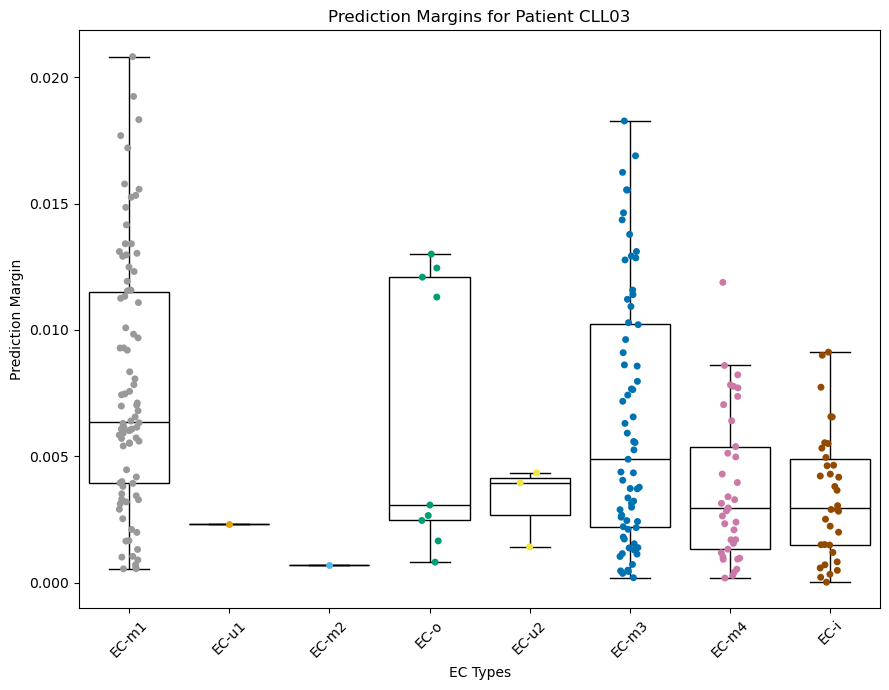

/tmp/ipykernel_2622972/2073152637.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='PrunedLabels', y='CorrelationDifference', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


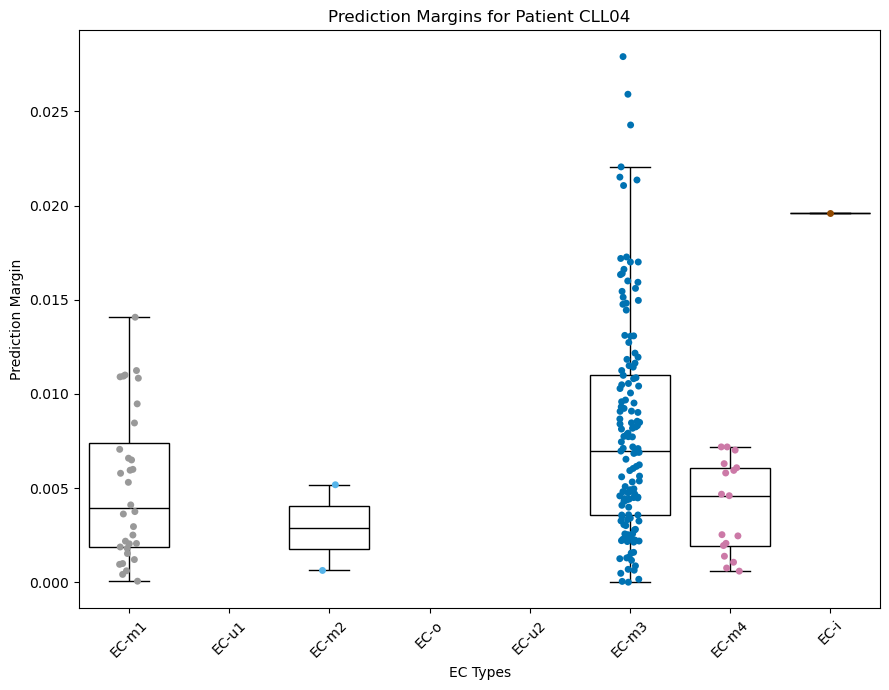

/tmp/ipykernel_2622972/2073152637.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='PrunedLabels', y='CorrelationDifference', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


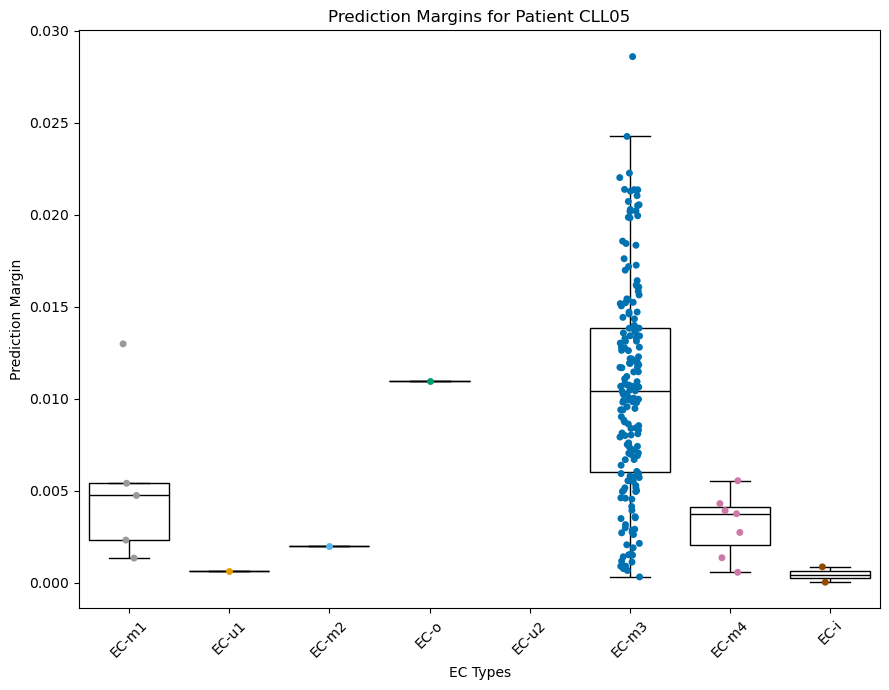

/tmp/ipykernel_2622972/2073152637.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='PrunedLabels', y='CorrelationDifference', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


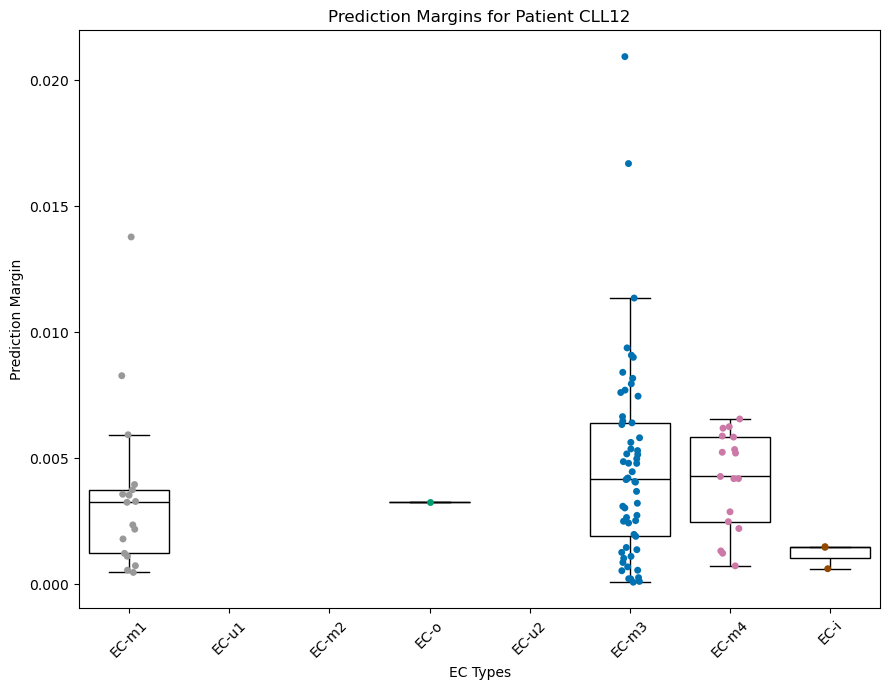

In [31]:
data_PrunedLabels = {'CellNames': list(cells_names), 'PrunedLabels': list(pruned_labels_vector)}
df_PrunedLabels = pd.DataFrame(data_PrunedLabels)

data_Labels = {'CellNames': list(cells_names), 'Labels': list(labels)}
df_Labels = pd.DataFrame(data_Labels)

# Prepare data for plotting
sample_to_ec_type = df_PrunedLabels
sample_to_ec_type['CLL_Type'] = sample_to_ec_type['CellNames'].apply(lambda x: x[:5])
sample_to_ec_type['Treatment'] = sample_to_ec_type['CellNames'].apply(lambda x: x.split('_')[1])

# Set the category order for EC_Type
EC_NAMES = ["EC-m1", "EC-u1", "EC-m2", "EC-o", "EC-u2", "EC-m3", "EC-m4", "EC-i"]
sample_to_ec_type['PrunedLabels'] = pd.Categorical(sample_to_ec_type['PrunedLabels'], categories=EC_NAMES, ordered=True)

# Define individual color lists
IGHV_MUT_COLORS = {"M-CLL": "#361379", "U-CLL": "#E65100"}
EPITYPE_COLORS = {"n-CLL": "#006E93", "i-CLL": "#FDC010", "m-CLL": "#963736"}
EC_COLOR_LIST = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#CC79A7", "#924900"]

# Create a dictionary mapping EC names to colors
EC_COLORS = dict(zip(EC_NAMES, EC_COLOR_LIST))
ALL_COLORS = {**IGHV_MUT_COLORS, **EPITYPE_COLORS, **EC_COLORS}

# Ensure white background for the plots
plt.style.use('default')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

# Calculate the difference between the highest and second highest correlation scores
highest_scores = []
second_highest_scores = []
correlation_differences = []

for i in range(scores_df.shape[0]):
    sorted_scores = scores_df.iloc[i, :].sort_values(ascending=False)
    highest_score = sorted_scores.iloc[0]  # Highest score
    second_highest_score = sorted_scores.iloc[1]  # Second highest score
    highest_scores.append(highest_score)
    second_highest_scores.append(second_highest_score)
    correlation_differences.append(highest_score - second_highest_score)

# Add the scores and differences to the dataframe
sample_to_ec_type['HighestScore'] = highest_scores
sample_to_ec_type['SecondHighestScore'] = second_highest_scores
sample_to_ec_type['CorrelationDifference'] = correlation_differences

# Create box plots of correlation differences for each CLL type, grouped by EC type
for cll_type in sample_to_ec_type['CLL_Type'].unique():
    subset_data = sample_to_ec_type[sample_to_ec_type['CLL_Type'] == cll_type]
    if not subset_data.empty:
        plt.figure(figsize=(9, 7))
        sns.boxplot(
            x='PrunedLabels', y='CorrelationDifference', data=subset_data, order=EC_NAMES,
            boxprops=dict(facecolor='white', edgecolor='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            medianprops=dict(color='black'),
            showfliers=False
        )
        sns.stripplot(x='PrunedLabels', y='CorrelationDifference', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)
        plt.xlabel('EC Types')
        plt.ylabel('Prediction Margin')
        plt.title(f'Prediction Margins for Patient {cll_type}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


In [25]:
from rpy2.robjects import pandas2ri

# Activate conversion from R to pandas DataFrame
pandas2ri.activate()

# Convert R data frames to pandas DataFrames
scores_df = pd.DataFrame(list_data.rx2('scores'))
delta_next_vector = list_data.rx2('delta.next')
pruned_labels_vector = list_data.rx2('pruned.labels')
labels = list_data.rx2('labels')
cells_names = r['slot'](result, 'rownames')
genes_name = r['slot'](result, 'metadata')


In [26]:
data_PrunedLabels = {    'CellNames': list(cells_names),
            'PrunedLabels': list(pruned_labels_vector)}
df_PrunedLabels = pd.DataFrame(data_PrunedLabels)

data_Labels = {    'CellNames': list(cells_names),
            'Labels': list(labels)}
df_Labels = pd.DataFrame(data_Labels)

/tmp/ipykernel_2622972/290804904.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='PrunedLabels', y='CorrelationDifference', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


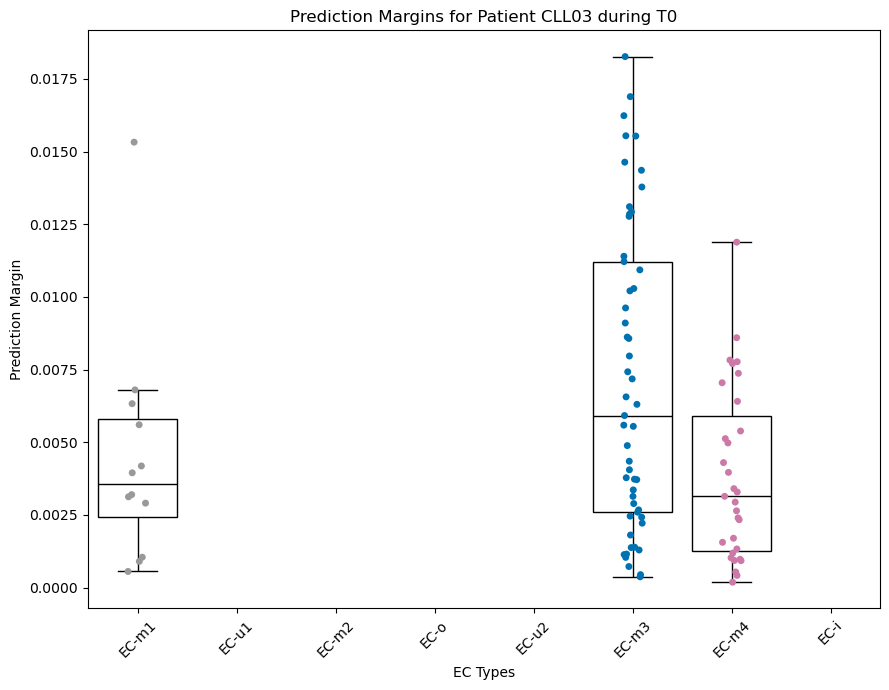

/tmp/ipykernel_2622972/290804904.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='PrunedLabels', y='CorrelationDifference', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


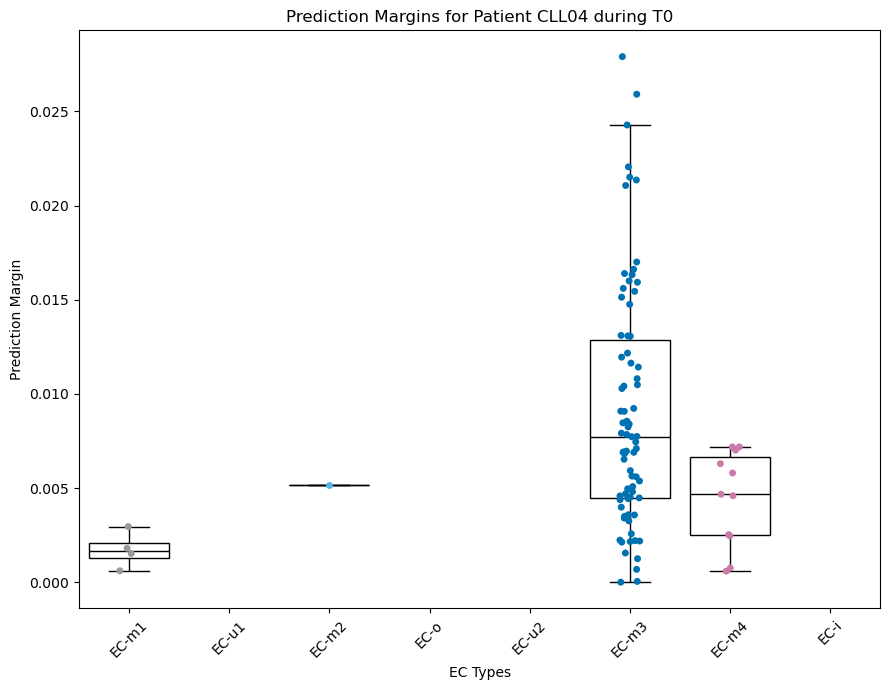

/tmp/ipykernel_2622972/290804904.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='PrunedLabels', y='CorrelationDifference', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


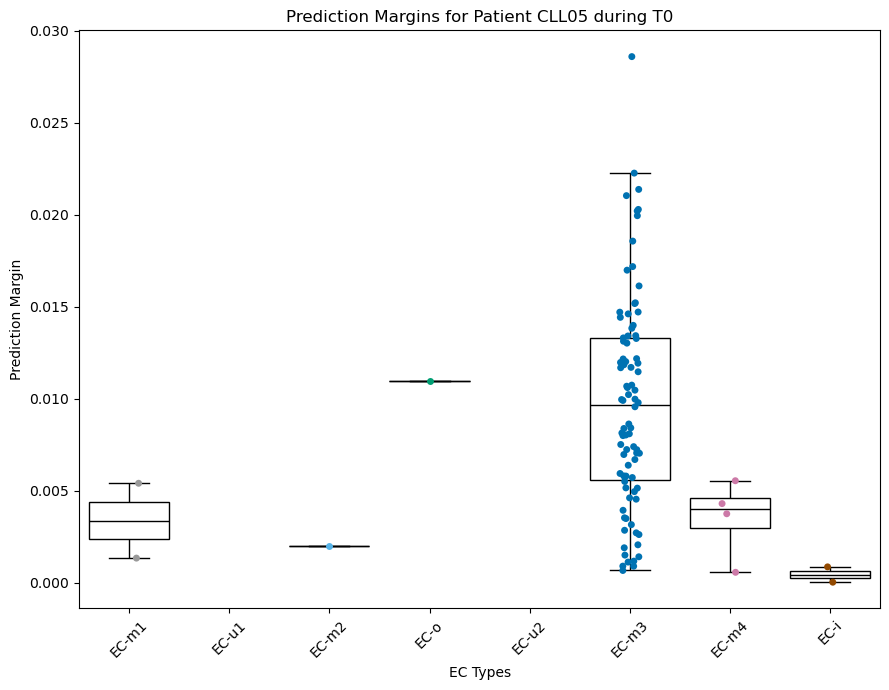

/tmp/ipykernel_2622972/290804904.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='PrunedLabels', y='CorrelationDifference', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


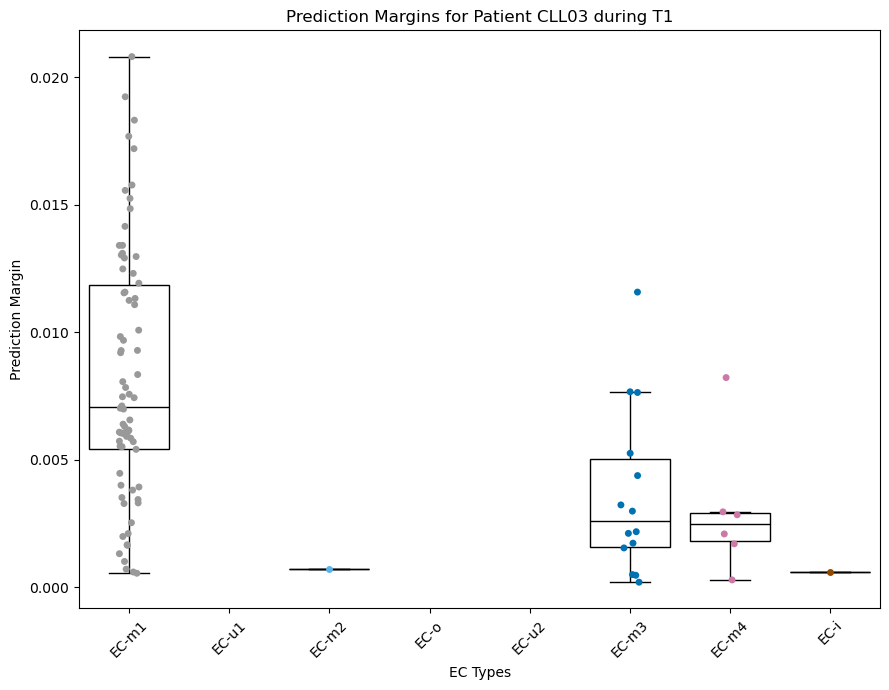

/tmp/ipykernel_2622972/290804904.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='PrunedLabels', y='CorrelationDifference', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


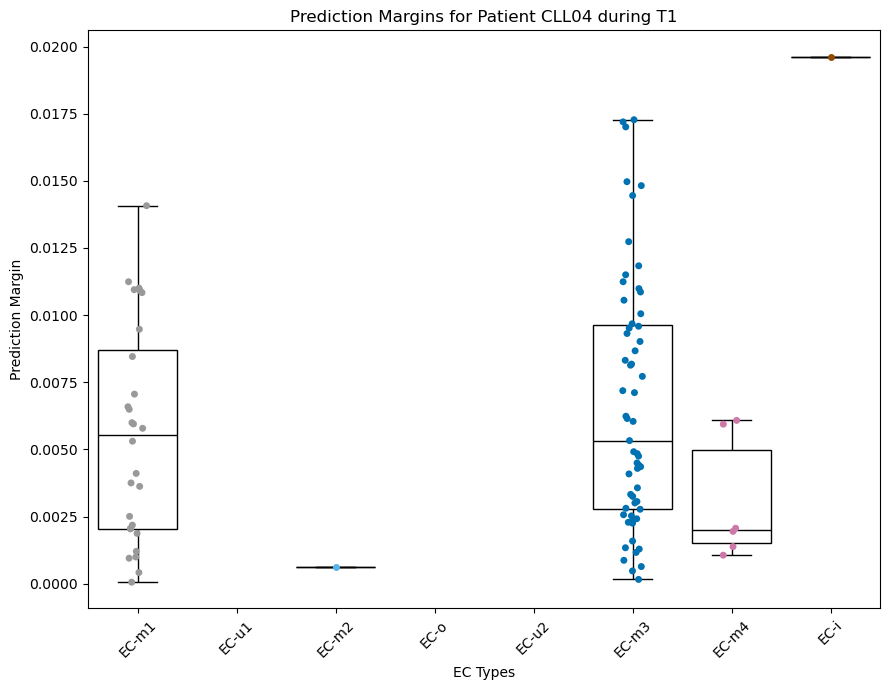

/tmp/ipykernel_2622972/290804904.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='PrunedLabels', y='CorrelationDifference', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


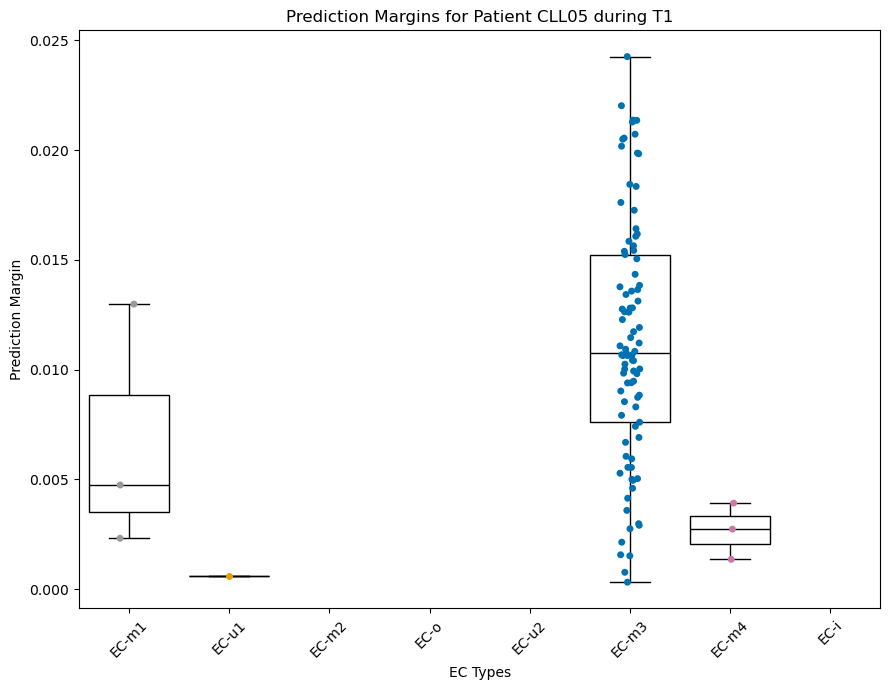

/tmp/ipykernel_2622972/290804904.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='PrunedLabels', y='CorrelationDifference', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


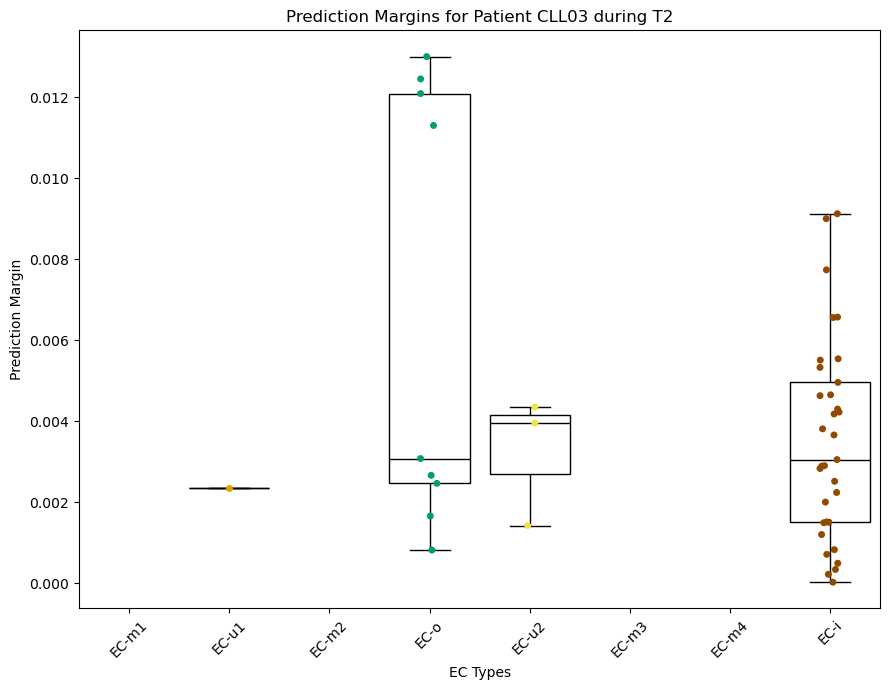

/tmp/ipykernel_2622972/290804904.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='PrunedLabels', y='CorrelationDifference', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)


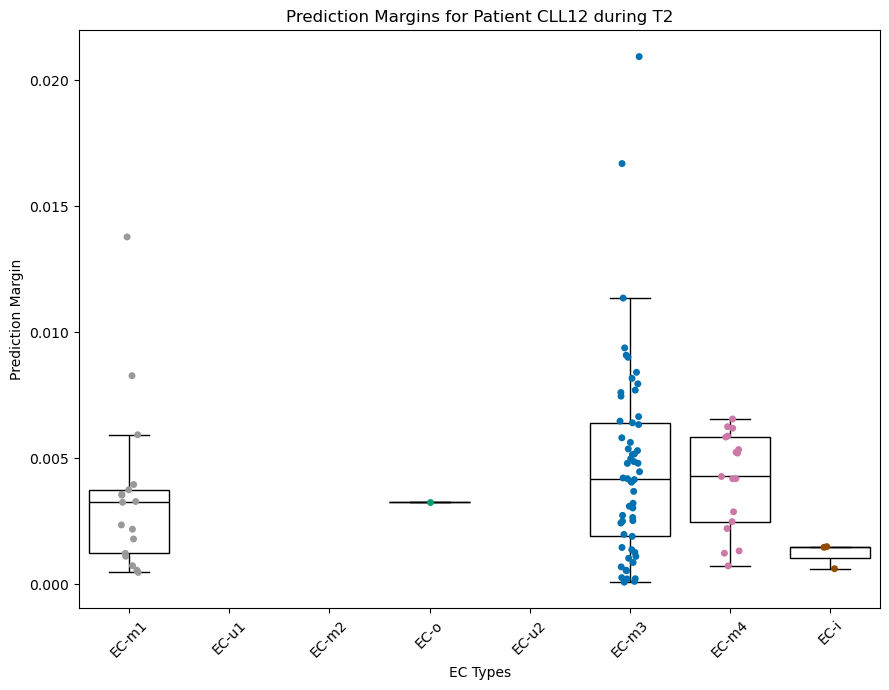

In [34]:
# Add a new column for treatment stage (T0 or T1)
sample_to_ec_type['TreatmentStage'] = sample_to_ec_type['CellNames'].apply(
    lambda x: 'T0' if 'T0' in x else ('T1' if 'T1' in x else 'T2')
)

# Calculate the difference between the highest and second highest correlation scores
highest_scores = []
second_highest_scores = []
correlation_differences = []

for i in range(scores_df.shape[0]):
    sorted_scores = scores_df.iloc[i, :].sort_values(ascending=False)
    highest_score = sorted_scores.iloc[0]  # Highest score
    second_highest_score = sorted_scores.iloc[1]  # Second highest score
    highest_scores.append(highest_score)
    second_highest_scores.append(second_highest_score)
    correlation_differences.append(highest_score - second_highest_score)

# Add the scores and differences to the dataframe
sample_to_ec_type['HighestScore'] = highest_scores
sample_to_ec_type['SecondHighestScore'] = second_highest_scores
sample_to_ec_type['CorrelationDifference'] = correlation_differences

# Create box plots of correlation differences for each treatment stage, grouped by EC type
for treatment_stage in sample_to_ec_type['TreatmentStage'].unique():
    for cll_type in sample_to_ec_type['CLL_Type'].unique():
        subset_data = sample_to_ec_type[(sample_to_ec_type['CLL_Type'] == cll_type) & 
                                        (sample_to_ec_type['TreatmentStage'] == treatment_stage)]
        if not subset_data.empty:
            plt.figure(figsize=(9, 7))
            sns.boxplot(
                x='PrunedLabels', y='CorrelationDifference', data=subset_data, order=EC_NAMES,
                boxprops=dict(facecolor='white', edgecolor='black'),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'),
                medianprops=dict(color='black'),
                showfliers=False
            )
            sns.stripplot(x='PrunedLabels', y='CorrelationDifference', data=subset_data, jitter=True, palette=EC_COLORS, size=5, order=EC_NAMES)
            plt.xlabel('EC Types')
            plt.ylabel('Prediction Margin')
            plt.title(f'Prediction Margins for Patient {cll_type} during {treatment_stage}')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()


In [28]:
df_Labels

,CellNames,Labels
0,CLL03_T0_cDNA_A10_S202,EC-m3
1,CLL03_T0_cDNA_A11_S203,EC-m3
2,CLL03_T0_cDNA_A12_S204,EC-m3
3,CLL03_T0_cDNA_A1_S193,EC-m3
4,CLL03_T0_cDNA_A2_S194,EC-m4
...,...,...
715,CLL12_cDNA_H5_S185,EC-m1
716,CLL12_cDNA_H6_S186,EC-m3
717,CLL12_cDNA_H7_S187,EC-m3
718,CLL12_cDNA_H9_S189,EC-m3


{'EC-m1': '#999999', 'EC-u1': '#E69F00', 'EC-m2': '#56B4E9', 'EC-o': '#009E73', 'EC-u2': '#F0E442', 'EC-m3': '#0072B2', 'EC-m4': '#CC79A7', 'EC-i': '#924900'}


/tmp/ipykernel_2622972/121186297.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='PrunedLabels', data=sample_to_ec_type[(sample_to_ec_type['CLL_Type'] == cll_type) & (sample_to_ec_type['Treatment'] == treatment)], palette=EC_COLORS)


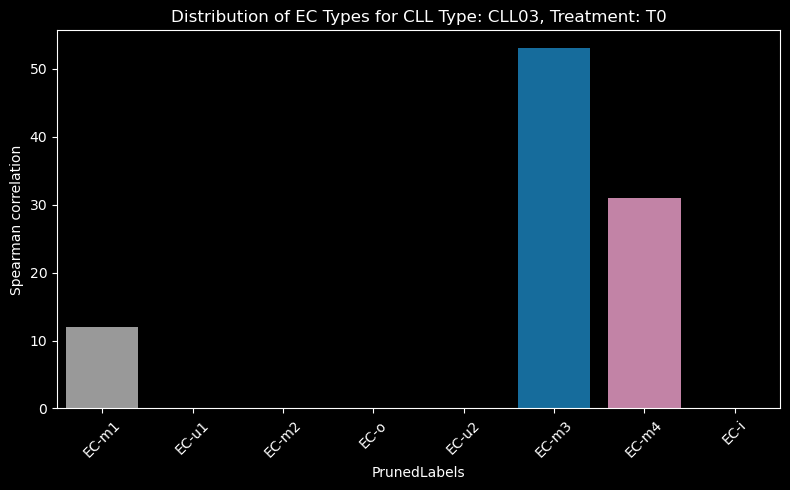

/tmp/ipykernel_2622972/121186297.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='PrunedLabels', data=sample_to_ec_type[(sample_to_ec_type['CLL_Type'] == cll_type) & (sample_to_ec_type['Treatment'] == treatment)], palette=EC_COLORS)


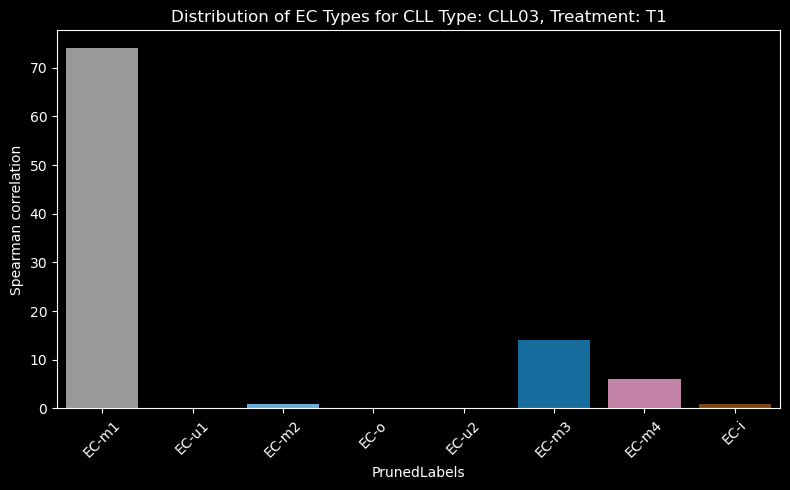

/tmp/ipykernel_2622972/121186297.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='PrunedLabels', data=sample_to_ec_type[(sample_to_ec_type['CLL_Type'] == cll_type) & (sample_to_ec_type['Treatment'] == treatment)], palette=EC_COLORS)


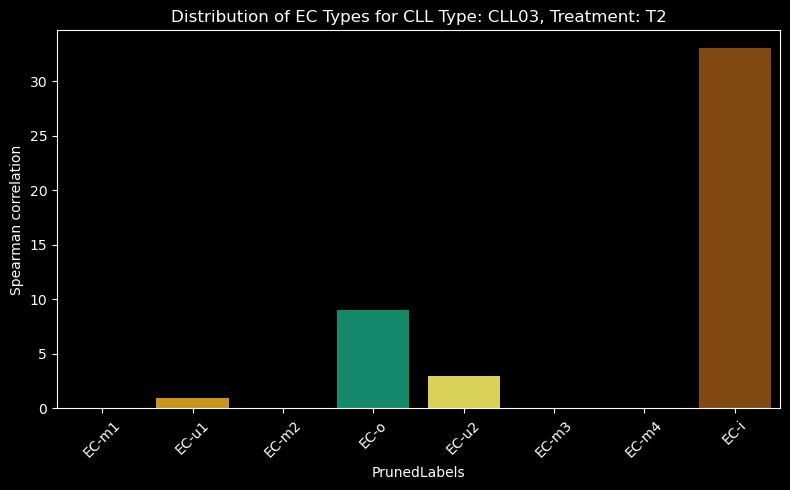

/tmp/ipykernel_2622972/121186297.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='PrunedLabels', data=sample_to_ec_type[(sample_to_ec_type['CLL_Type'] == cll_type) & (sample_to_ec_type['Treatment'] == treatment)], palette=EC_COLORS)


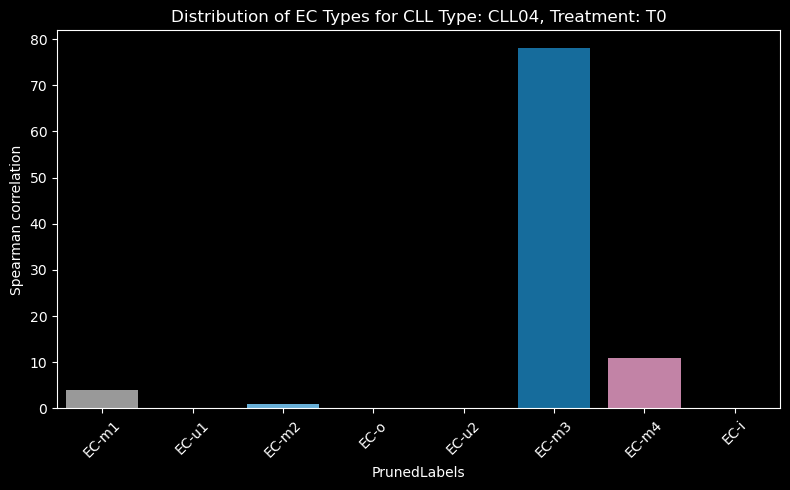

/tmp/ipykernel_2622972/121186297.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='PrunedLabels', data=sample_to_ec_type[(sample_to_ec_type['CLL_Type'] == cll_type) & (sample_to_ec_type['Treatment'] == treatment)], palette=EC_COLORS)


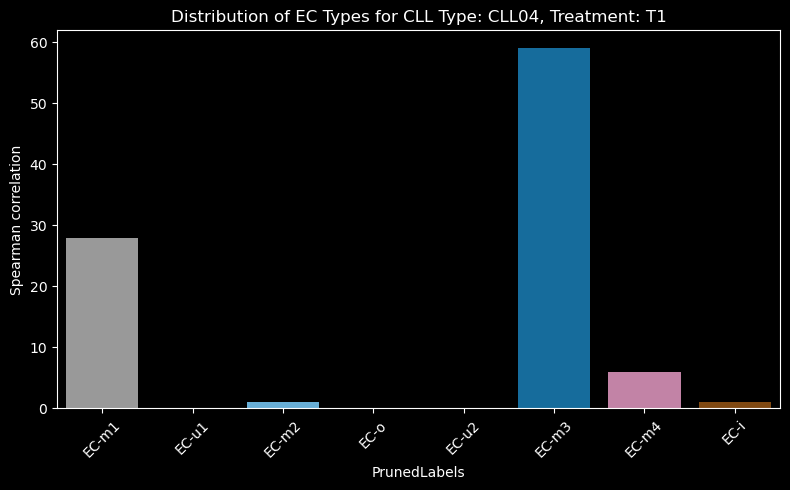

/tmp/ipykernel_2622972/121186297.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='PrunedLabels', data=sample_to_ec_type[(sample_to_ec_type['CLL_Type'] == cll_type) & (sample_to_ec_type['Treatment'] == treatment)], palette=EC_COLORS)


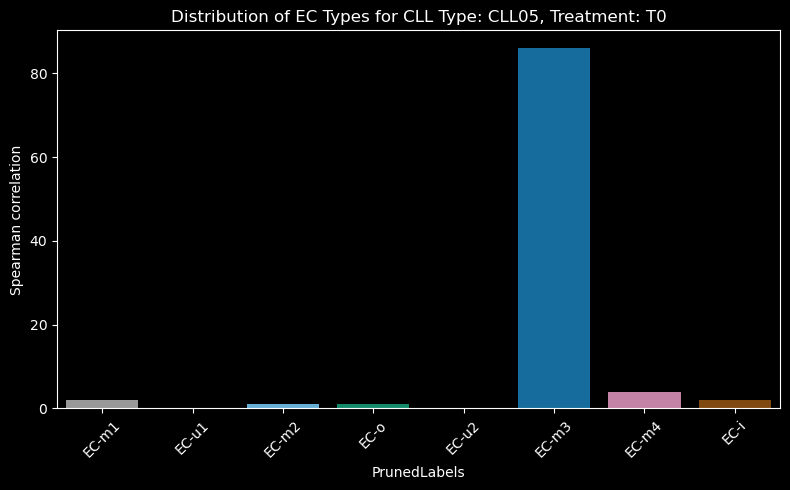

/tmp/ipykernel_2622972/121186297.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='PrunedLabels', data=sample_to_ec_type[(sample_to_ec_type['CLL_Type'] == cll_type) & (sample_to_ec_type['Treatment'] == treatment)], palette=EC_COLORS)


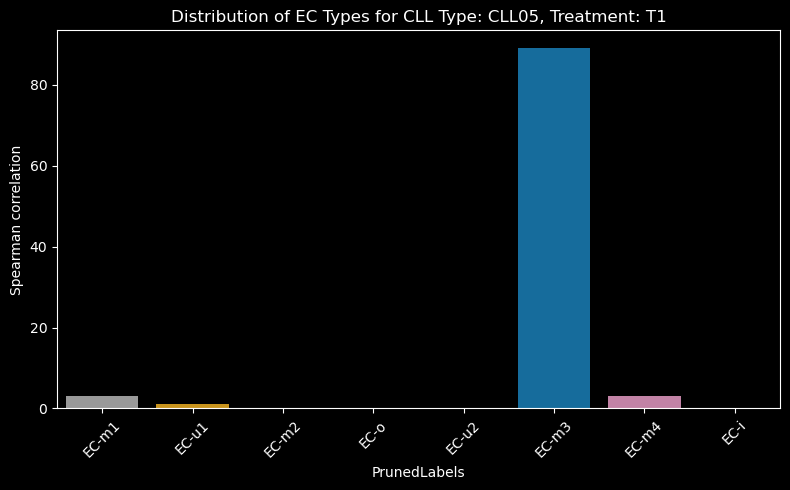

/tmp/ipykernel_2622972/121186297.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='PrunedLabels', data=sample_to_ec_type[(sample_to_ec_type['CLL_Type'] == cll_type) & (sample_to_ec_type['Treatment'] == treatment)], palette=EC_COLORS)


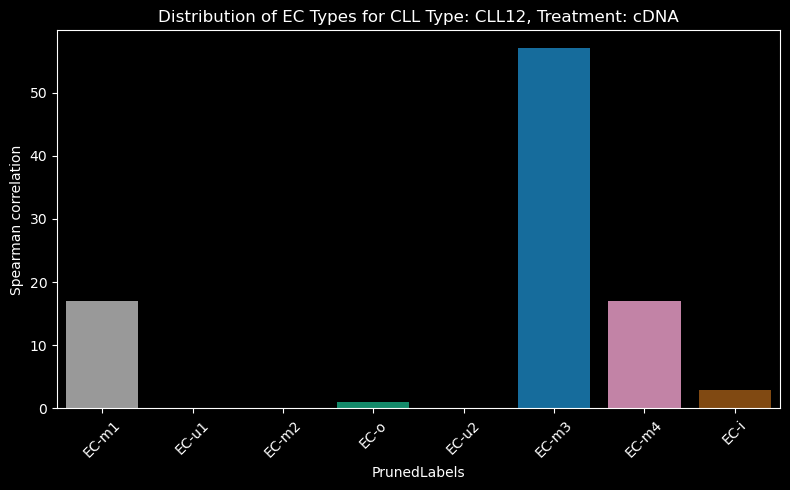

In [29]:
sample_to_ec_type = df_PrunedLabels
sample_to_ec_type['CLL_Type'] = sample_to_ec_type['CellNames'].apply(lambda x: x[:5])
sample_to_ec_type['Treatment'] = sample_to_ec_type['CellNames'].apply(lambda x: x.split('_')[1])

# Set the category order for EC_Type
EC_NAMES = ["EC-m1", "EC-u1", "EC-m2", "EC-o", "EC-u2", "EC-m3", "EC-m4", "EC-i"]
sample_to_ec_type['PrunedLabels'] = pd.Categorical(sample_to_ec_type['PrunedLabels'], categories=EC_NAMES, ordered=True)

# Define individual color lists
IGHV_MUT_COLORS = {"M-CLL": "#361379", "U-CLL": "#E65100"}
EPITYPE_COLORS = {"n-CLL": "#006E93", "i-CLL": "#FDC010", "m-CLL": "#963736"}
# EC_NAMES = ["EC-m1", "EC-u1", "EC-m2", "EC-o", "EC-u2", "EC-m3", "EC-m4", "EC-i"]
EC_COLOR_LIST = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#CC79A7", "#924900"]

# Create a dictionary mapping EC names to colors
EC_COLORS = dict(zip(EC_NAMES, EC_COLOR_LIST))
print(EC_COLORS)

# Combine all dictionaries into a single comprehensive dictionary
ALL_COLORS = {**IGHV_MUT_COLORS, **EPITYPE_COLORS, **EC_COLORS}

# # Plot the data
# plt.figure(figsize=(8, 5))

# Plot the data
for cll_type in sample_to_ec_type['CLL_Type'].unique():
    for treatment in sample_to_ec_type[sample_to_ec_type['CLL_Type'] == cll_type]['Treatment'].unique():
        plt.figure(figsize=(8, 5))
        ax = sns.countplot(x='PrunedLabels', data=sample_to_ec_type[(sample_to_ec_type['CLL_Type'] == cll_type) & (sample_to_ec_type['Treatment'] == treatment)], palette=EC_COLORS)
        plt.title(f'Distribution of EC Types for CLL Type: {cll_type}, Treatment: {treatment}')
        
        plt.ylabel('Spearman correlation')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

/tmp/ipykernel_2239258/2207858771.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Labels', data=sample_to_ec_type[(sample_to_ec_type['CLL_Type'] == cll_type) & (sample_to_ec_type['Treatment'] == treatment)], palette=EC_COLORS)


{'EC-m1': '#999999', 'EC-u1': '#E69F00', 'EC-m2': '#56B4E9', 'EC-o': '#009E73', 'EC-u2': '#F0E442', 'EC-m3': '#0072B2', 'EC-m4': '#CC79A7', 'EC-i': '#924900'}


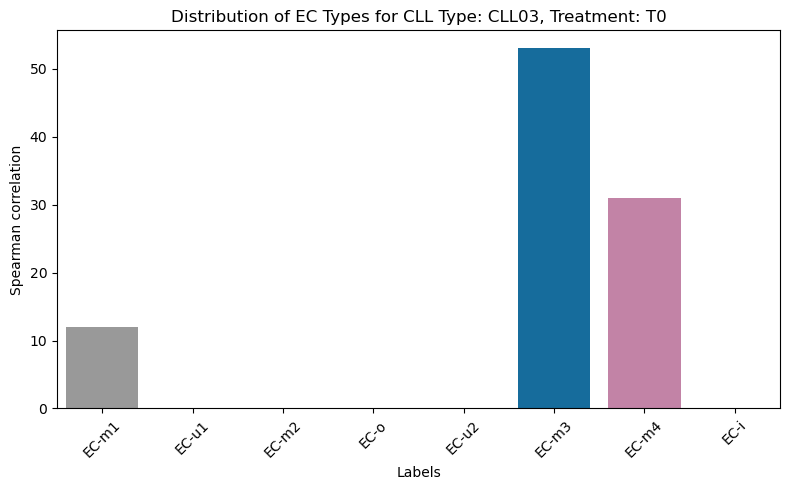

/tmp/ipykernel_2239258/2207858771.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Labels', data=sample_to_ec_type[(sample_to_ec_type['CLL_Type'] == cll_type) & (sample_to_ec_type['Treatment'] == treatment)], palette=EC_COLORS)


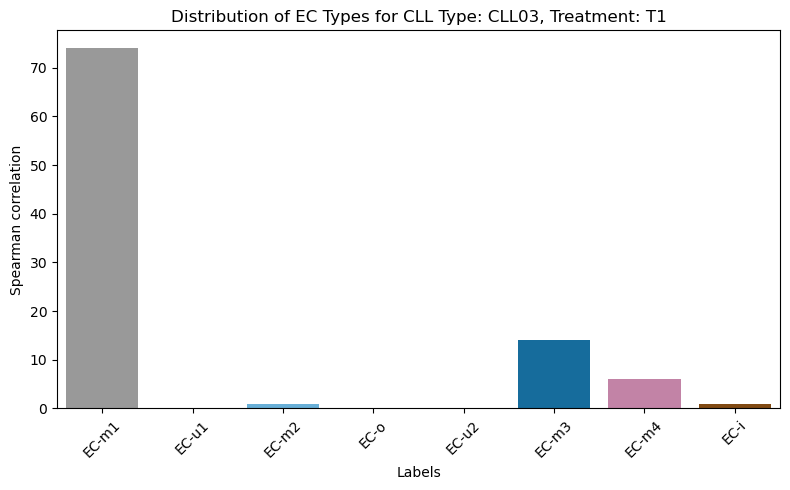

/tmp/ipykernel_2239258/2207858771.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Labels', data=sample_to_ec_type[(sample_to_ec_type['CLL_Type'] == cll_type) & (sample_to_ec_type['Treatment'] == treatment)], palette=EC_COLORS)


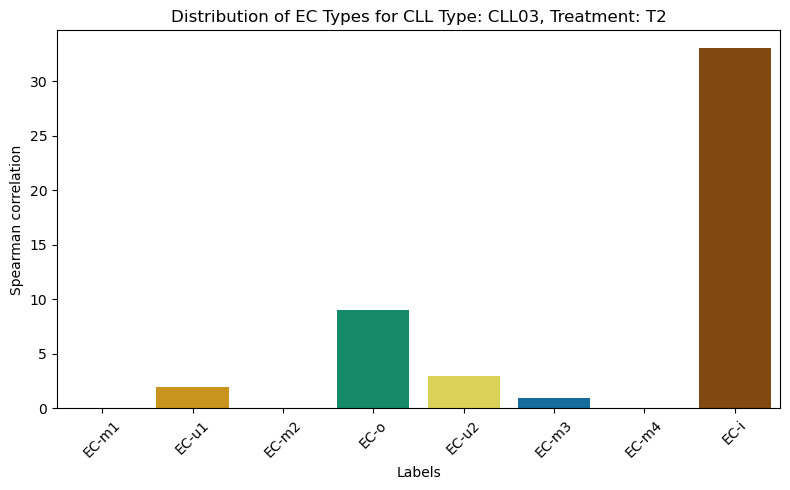

/tmp/ipykernel_2239258/2207858771.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Labels', data=sample_to_ec_type[(sample_to_ec_type['CLL_Type'] == cll_type) & (sample_to_ec_type['Treatment'] == treatment)], palette=EC_COLORS)


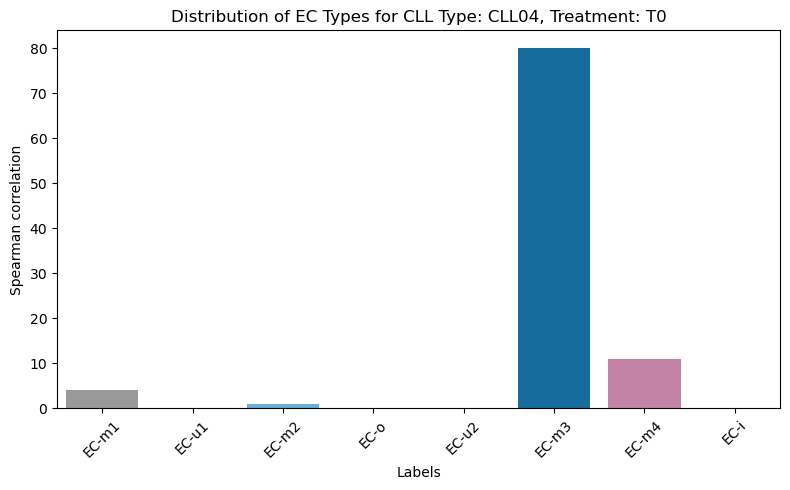

/tmp/ipykernel_2239258/2207858771.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Labels', data=sample_to_ec_type[(sample_to_ec_type['CLL_Type'] == cll_type) & (sample_to_ec_type['Treatment'] == treatment)], palette=EC_COLORS)


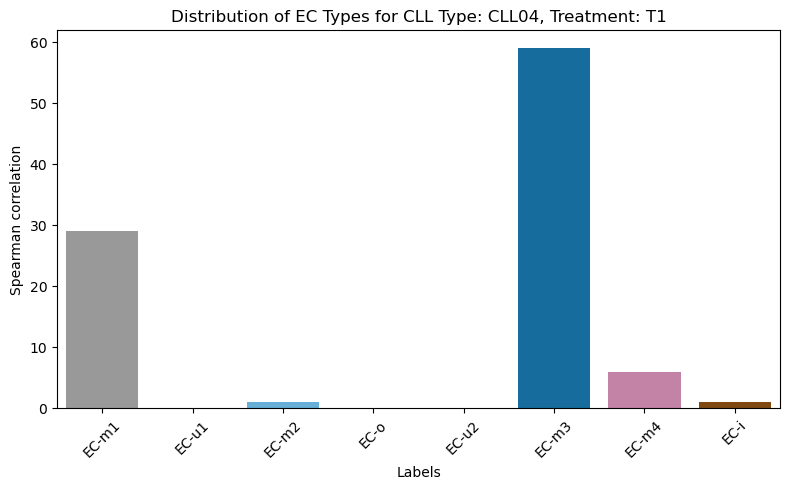

/tmp/ipykernel_2239258/2207858771.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Labels', data=sample_to_ec_type[(sample_to_ec_type['CLL_Type'] == cll_type) & (sample_to_ec_type['Treatment'] == treatment)], palette=EC_COLORS)


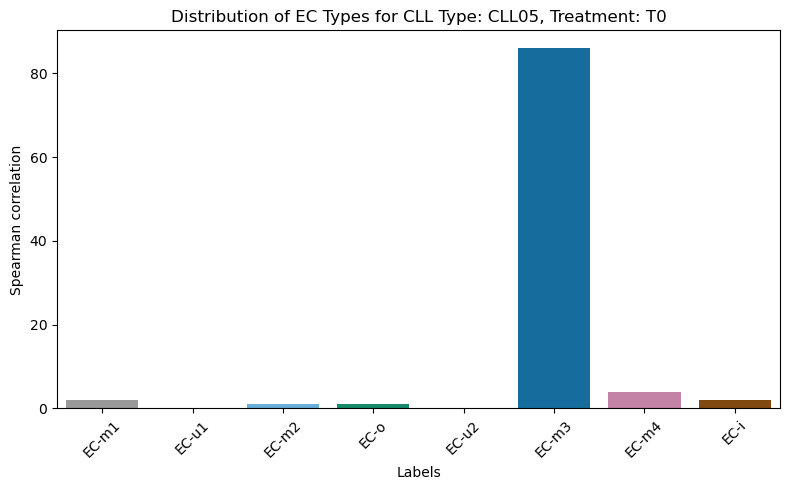

/tmp/ipykernel_2239258/2207858771.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Labels', data=sample_to_ec_type[(sample_to_ec_type['CLL_Type'] == cll_type) & (sample_to_ec_type['Treatment'] == treatment)], palette=EC_COLORS)


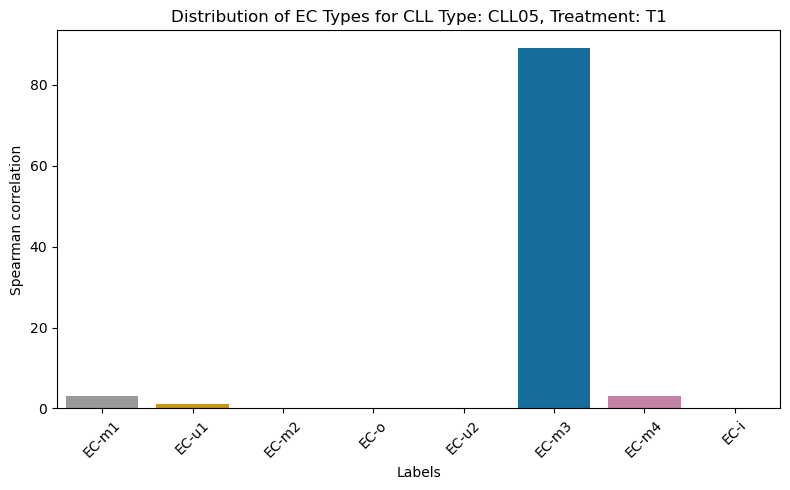

/tmp/ipykernel_2239258/2207858771.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Labels', data=sample_to_ec_type[(sample_to_ec_type['CLL_Type'] == cll_type) & (sample_to_ec_type['Treatment'] == treatment)], palette=EC_COLORS)


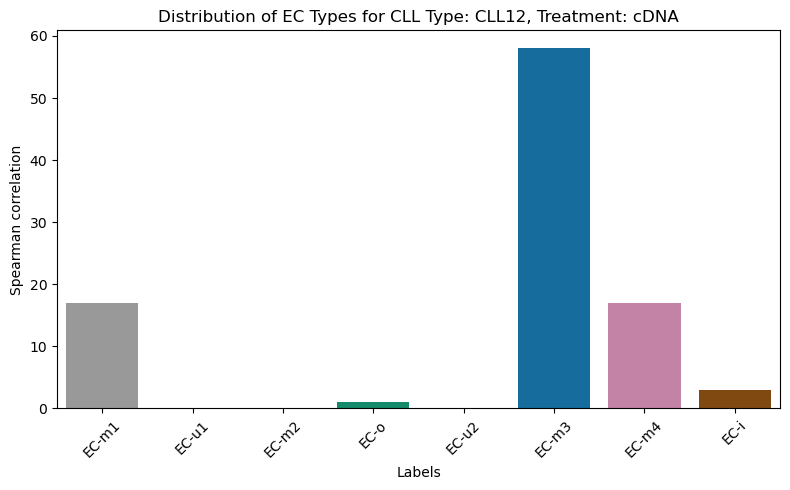

In [26]:
sample_to_ec_type = df_Labels
sample_to_ec_type['CLL_Type'] = sample_to_ec_type['CellNames'].apply(lambda x: x[:5])
sample_to_ec_type['Treatment'] = sample_to_ec_type['CellNames'].apply(lambda x: x.split('_')[1])

# Set the category order for EC_Type
EC_NAMES = ["EC-m1", "EC-u1", "EC-m2", "EC-o", "EC-u2", "EC-m3", "EC-m4", "EC-i"]
sample_to_ec_type['Labels'] = pd.Categorical(sample_to_ec_type['Labels'], categories=EC_NAMES, ordered=True)

# Define individual color lists
IGHV_MUT_COLORS = {"M-CLL": "#361379", "U-CLL": "#E65100"}
EPITYPE_COLORS = {"n-CLL": "#006E93", "i-CLL": "#FDC010", "m-CLL": "#963736"}
# EC_NAMES = ["EC-m1", "EC-u1", "EC-m2", "EC-o", "EC-u2", "EC-m3", "EC-m4", "EC-i"]
EC_COLOR_LIST = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#CC79A7", "#924900"]

# Create a dictionary mapping EC names to colors
EC_COLORS = dict(zip(EC_NAMES, EC_COLOR_LIST))
print(EC_COLORS)

# Combine all dictionaries into a single comprehensive dictionary
ALL_COLORS = {**IGHV_MUT_COLORS, **EPITYPE_COLORS, **EC_COLORS}

# # Plot the data
# plt.figure(figsize=(8, 5))

# Ensure white background for the plots
plt.style.use('default')
# Plot the data
for cll_type in sample_to_ec_type['CLL_Type'].unique():
    for treatment in sample_to_ec_type[sample_to_ec_type['CLL_Type'] == cll_type]['Treatment'].unique():
        plt.figure(figsize=(8, 5))
        ax = sns.countplot(x='Labels', data=sample_to_ec_type[(sample_to_ec_type['CLL_Type'] == cll_type) & (sample_to_ec_type['Treatment'] == treatment)], palette=EC_COLORS)
        plt.title(f'Distribution of EC Types for CLL Type: {cll_type}, Treatment: {treatment}')
        
        plt.ylabel('Spearman correlation')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [27]:
import numpy as np
import pandas as pd
from anndata import AnnData
from scipy.sparse import coo_matrix

# type-hint helpers
from typing import Optional

# R packages for the imputation / clustering
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri as np2ri


def scshc(
    adata: AnnData,
    alpha: float = 0.05,
    num_features: int = 2500,
    num_PCs: int = 30,
    parallel: bool = True,
    cores: int = 70,
    layer: Optional[str] = None,
    print_tree: bool = False,
    copy: bool = False,
) -> Optional[AnnData]:
    """
    Run scSHC on an AnnData object.
    :param adata: AnnData object
    :param alpha: significance level for the t-test
    :param num_features: number of features to select
    :param num_PCs: number of PCs to use
    :param parallel: whether to use parallel computation
    :param cores: number of cores to use
    :param copy: copy AnnData object
    :return: AnnData object if copy is True, otherwise None
    """
    Matrix = importr("Matrix")
    scSHC = importr("scSHC")
    adata = adata.copy() if copy else adata
    adata.uns["scshc"] = {
        "params": {
            "alpha": alpha,
            "num_features": num_features,
            "num_PCs": num_PCs,
            "layer": layer,
        }
    }
    X = adata.X if layer is None else adata.layers[layer]
    # Convert to coo sparse matrix
    r_adata = coo_matrix(X, dtype=int).T
    # Convert to R sparse matrix:
    # Create the lists for the Matrix constructor,
    # Add 1 to the indices due to R's 1-based indexing.
    i = np2ri.numpy2rpy(r_adata.row + 1)
    j = np2ri.numpy2rpy(r_adata.col + 1)
    x = np2ri.numpy2rpy(r_adata.data)
    dims = ro.IntVector([adata.n_vars, adata.n_obs])
    r_adata = Matrix.sparseMatrix(i=i, j=j, x=x, dims=dims)
    # Add Rownames and colnames to the sparse matrix
    rownames = ro.StrVector(adata.var_names.tolist())
    colnames = ro.StrVector(adata.obs_names.tolist())
    r_adata.do_slot_assign(
        "Dimnames", ro.ListVector({"rownames": rownames, "colnames": colnames})
    )
    # Run scSHC
    scshc_result = scSHC.scSHC(
        r_adata,
        alpha=alpha,
        num_features=num_features,
        num_PCs=num_PCs,
        parallel=parallel,
        cores=cores,
    )
    # Convert back and add the clusters to the AnnData object
    # Subtract 1 from the cluster ids to start from 0
    clusters = np.array(scshc_result[0], dtype=np.int8) - 1
    adata.uns["scshc"]["n_clusters"] = np.count_nonzero(np.bincount(clusters))
    adata.obs["scshc"] = pd.Categorical(
        values=clusters.astype("U"),
        categories=np.sort(np.unique(clusters)).astype("U"),
    )
    return adata if copy else None

In [28]:

# Convert R data frames to pandas DataFrames
pandas2ri.activate()
scores_df = pd.DataFrame(result.rx2('scores'))
delta_next_vector = result.rx2('delta.next')
pruned_labels_vector = result.rx2('pruned.labels')
labels = result.rx2('labels')
cells_names = r['slot'](result, 'rownames')
genes_name = r['slot'](result, 'metadata')

data_PrunedLabels = {'CellNames': list(cells_names), 'PrunedLabels': list(pruned_labels_vector)}
df_PrunedLabels = pd.DataFrame(data_PrunedLabels)

data_Labels = {'CellNames': list(cells_names), 'Labels': list(labels)}
df_Labels = pd.DataFrame(data_Labels)

# Prepare data for plotting
sample_to_ec_type = df_PrunedLabels
sample_to_ec_type['CLL_Type'] = sample_to_ec_type['CellNames'].apply(lambda x: x[:5])
sample_to_ec_type['Treatment'] = sample_to_ec_type['CellNames'].apply(lambda x: x.split('_')[1])

# Set the category order for EC_Type
EC_NAMES = ["EC-m1", "EC-u1", "EC-m2", "EC-o", "EC-u2", "EC-m3", "EC-m4", "EC-i"]
sample_to_ec_type['PrunedLabels'] = pd.Categorical(sample_to_ec_type['PrunedLabels'], categories=EC_NAMES, ordered=True)

# Define individual color lists
IGHV_MUT_COLORS = {"M-CLL": "#361379", "U-CLL": "#E65100"}
EPITYPE_COLORS = {"n-CLL": "#006E93", "i-CLL": "#FDC010", "m-CLL": "#963736"}
EC_COLOR_LIST = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#CC79A7", "#924900"]

# Create a dictionary mapping EC names to colors
EC_COLORS = dict(zip(EC_NAMES, EC_COLOR_LIST))
ALL_COLORS = {**IGHV_MUT_COLORS, **EPITYPE_COLORS, **EC_COLORS}

# Ensure white background for the plots
plt.style.use('default')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

# Get the second highest correlation labels
second_highest_labels = []
for i in range(scores_df.shape[0]):
    sorted_scores = scores_df.iloc[i, :].sort_values(ascending=False)
    second_highest_label = sorted_scores.index[1]  # Second highest label
    second_highest_labels.append(second_highest_label)

# Add the second highest labels to the dataframe
sample_to_ec_type['SecondHighestLabel'] = second_highest_labels

# Plot the data
for cll_type in sample_to_ec_type['CLL_Type'].unique():
    for treatment in sample_to_ec_type[sample_to_ec_type['CLL_Type'] == cll_type]['Treatment'].unique():
        plt.figure(figsize=(8, 5))
        ax = sns.countplot(x='PrunedLabels', data=sample_to_ec_type[(sample_to_ec_type['CLL_Type'] == cll_type) & (sample_to_ec_type['Treatment'] == treatment)], palette=EC_COLORS)
        plt.title(f'Distribution of EC Types for CLL Type: {cll_type}, Treatment: {treatment}')
        plt.ylabel('Spearman correlation')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Print second highest labels
print(sample_to_ec_type[['CellNames', 'PrunedLabels', 'SecondHighestLabel']])


/data01/home/ls/razlans/miniforge3/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data01/home/ls/razlans/miniforge3/envs/sc/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipykernel_2239258/3517331217.py:48: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  an.activate()
/data01/home/ls/razlans/miniforge3/envs/sc/lib/python3.12/functools.py:909: UserWarning: Duplicated var_names: Index(['5S_rRNA', '5S_rRNA', '5S_rRNA', '5S_rRNA', '5S_rRNA', '5S_rRNA',
       '5S_rRNA', '7SK', '7SK', '7SK',
       ...
       'snoU13', 'snoU2_19', 'snoU2_19', 'snoU2_19', 'snoZ6', 'snoZ6', 'snoZ6',
     

ValueError: Data must be 1-dimensional, got ndarray of shape (720, 8) instead